### EDA
Проведем разведочный анализ нашего датасета. В процесс посмотрим на пустые значения и на выбросы.

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/MelnikDM/Netology/main/CRISP_DM/WIne_Quality/data/raw/winequalityN.csv', sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [12]:
df.type.value_counts()

white    4898
red      1599
Name: type, dtype: int64

In [13]:
df.quality.value_counts().to_frame()

,quality
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


Взглянем на пропуски

In [14]:
def NaN_dataplot(df:pd.DataFrame):
    ''' Данная функция:
        - подсчитывает количество NaN по столбцам
        - подсчитывает общее количество NaN по столбцам в %
        - подсчитывает количество NaN по строкам
        - строит 2 графика с NaN по столбцам и строкам'''
    total= df.size # общее количество записей
    NaNCount = df.isnull().sum() # количество NaN по столбцам
    NaNtotal = NaNCount.sum() # общее количество NaN
    print("DF содержит", round(((NaNtotal/total) * 100), 2), "%", "пропущенных значений")
    print()

    missing = NaNCount[NaNCount > 0] 
    missing.sort_values(inplace=True) 
    print(missing)
    print()
    print('Пропущенно по строкам')
    print()
    rowNaN = df.isnull().sum(axis=1).value_counts()
    print(rowNaN)

In [15]:
NaN_dataplot(df)

DF содержит 0.04 % пропущенных значений

residual sugar       2
chlorides            2
citric acid          3
sulphates            4
volatile acidity     8
pH                   9
fixed acidity       10
dtype: int64

Пропущенно по строкам

0    6463
1      30
2       4
dtype: int64


Пропусков не так много, поэтому просто удалим их.

In [16]:
df_d = df.dropna(axis=0)
NaN_dataplot(df_d)

DF содержит 0.0 % пропущенных значений

Series([], dtype: int64)

Пропущенно по строкам

0    6463
dtype: int64


В таблице ниже показано распределение каждого числового признака в наборе данных. Среднее значение и стандартное отклонение варьируются в зависимости от различных характеристик. На данном этапе можно сказать, что нам придется скалировать наши данные, так как наблюдается существенная разбежка в значениях, например, общего диоксида серы и лимонной кислоты.

In [17]:
df_d.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,5.818505
std,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.873286
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


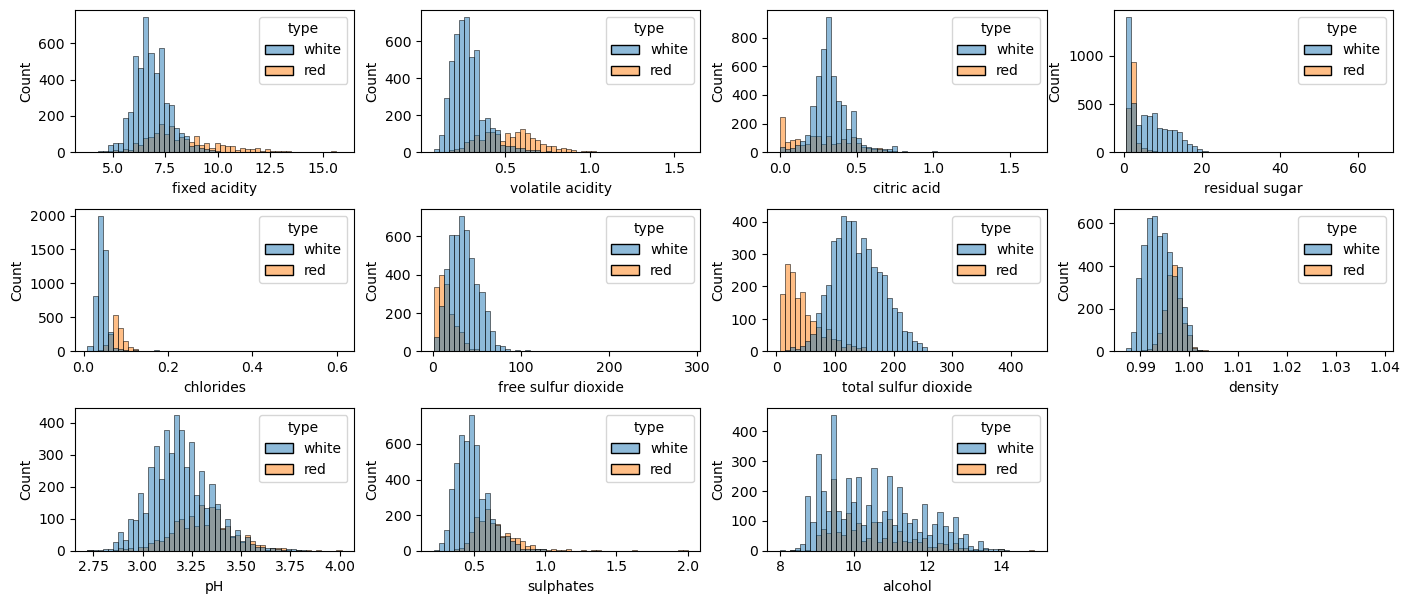

In [18]:
columns = df_d.drop(['quality', 'type'], axis = 1)
x = columns
fig, axs = plt.subplots(3,4, figsize=(14, 6))
fig.tight_layout (h_pad=2)
fig.delaxes(ax=axs[2,3])
axs = axs.flatten()
for i, k in enumerate(columns):
    sns.histplot(data=df_d,
                 x = x[k],
                 ax = axs[i],
                 hue="type",
                 bins = 50)

Похоже по ряду признаков у нас есть очевидные выбросы. Уберем их стандартным методом - все, что выше 3 стандартных отклонений, то удалим.

In [19]:
def remove_outliers(df, columns, n_std):
    for col in columns:
        print('Удаляем выбросы в колонке: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

In [20]:
columns = df_d.drop(['quality', 'type'], axis = 1)
df_out = remove_outliers(df_d, columns, 3)
df_out.describe()

Удаляем выбросы в колонке: fixed acidity
Удаляем выбросы в колонке: volatile acidity
Удаляем выбросы в колонке: citric acid
Удаляем выбросы в колонке: residual sugar
Удаляем выбросы в колонке: chlorides
Удаляем выбросы в колонке: free sulfur dioxide
Удаляем выбросы в колонке: total sulfur dioxide
Удаляем выбросы в колонке: density
Удаляем выбросы в колонке: pH
Удаляем выбросы в колонке: sulphates
Удаляем выбросы в колонке: alcohol


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000,5907.000000
mean,7.096335,0.326668,0.310007,5.501083,0.051410,30.650330,117.781615,0.994496,3.217811,0.517880,10.511621,5.841036
std,1.051842,0.146023,0.128770,4.638574,0.020535,16.360706,54.362091,0.002864,0.154015,0.125299,1.194056,0.864874
min,3.900000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.220000,0.250000,1.800000,0.037000,18.000000,84.000000,0.992150,3.110000,0.430000,9.500000,5.000000
50%,6.900000,0.290000,0.310000,3.200000,0.046000,29.000000,119.000000,0.994700,3.210000,0.500000,10.400000,6.000000
75%,7.600000,0.390000,0.380000,8.200000,0.059000,41.000000,156.000000,0.996785,3.320000,0.590000,11.300000,6.000000
max,11.100000,0.830000,0.730000,19.500000,0.152000,83.000000,278.000000,1.002600,3.690000,0.940000,14.050000,9.000000


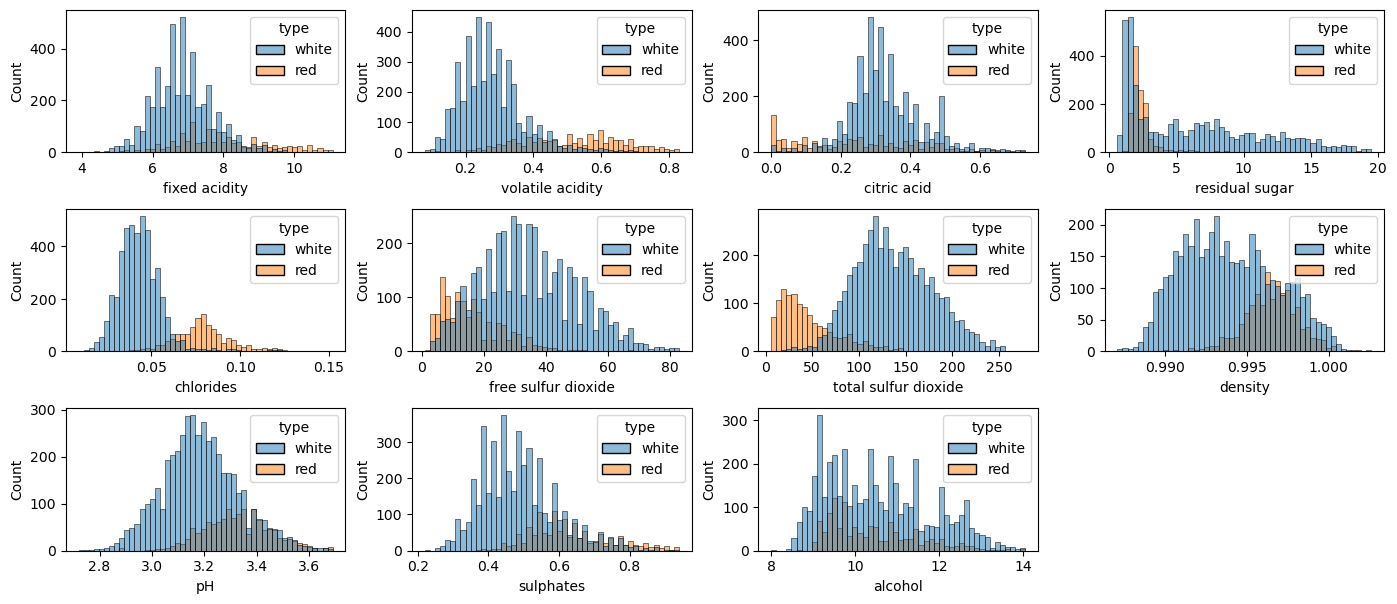

In [21]:
columns = df_out.drop(['quality', 'type'], axis = 1)
x = columns
fig, axs = plt.subplots(3,4, figsize=(14, 6))
fig.tight_layout (h_pad=2)
fig.delaxes(ax=axs[2,3])
axs = axs.flatten()
for i, k in enumerate(columns):
    sns.histplot(data=df_out,
                 x = x[k],
                 ax = axs[i],
                 hue="type",
                 bins = 50)
    
plt.savefig('E:/Repositories/Projects/SVO/Netology/CRISP_DM/WIne_Quality/reports/histplot.png')

#### Корреляционный анализ

Посмотрим на тесноту и направление связи наших признаков. Для этого построим тепловую карту.

"Силу" взаимосвязей обозначим таким образом:

- 0.1 - 0.3 - Слабая взаимосвязь
- 0.3 - 0.5 - Умеренная взаимосвязь
- 0.5 - 0.7 - Заметная взаимосвязь
- 0.7 - 0.9 - Высокая взаимосвязь
- 0.9 - 1 - Весьма высокая взаимосвязь

C:\Users\db2020\AppData\Local\Temp\ipykernel_12680\2554790586.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_out.corr(),


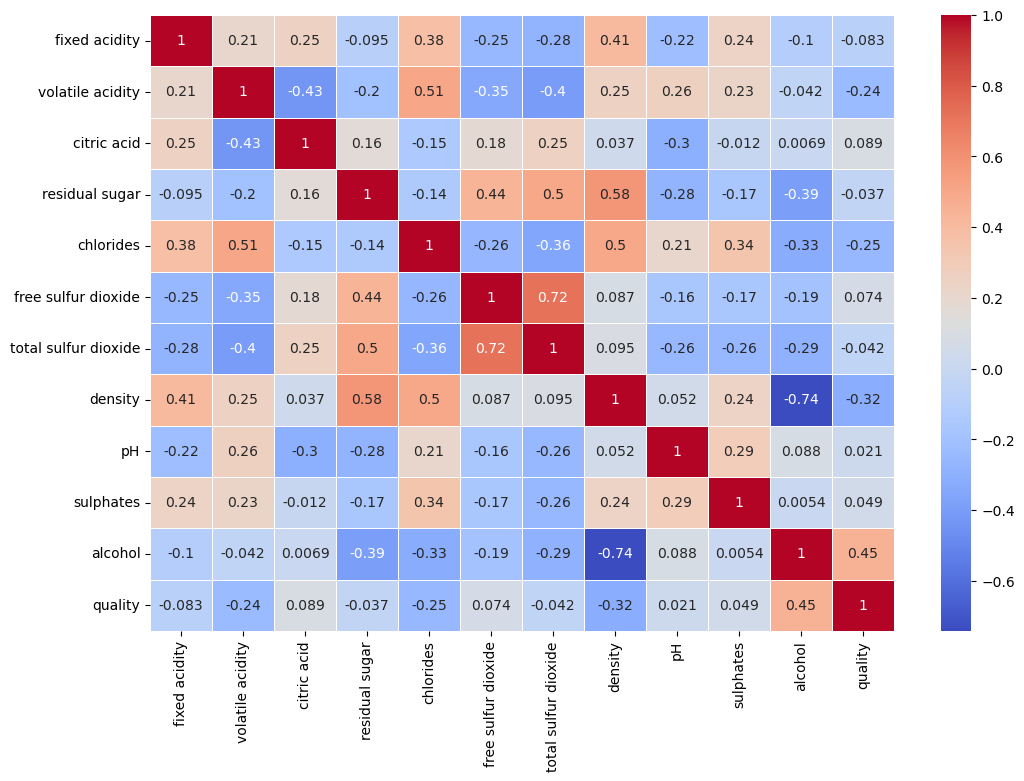

In [22]:
fg, axes = plt.subplots(figsize=(12, 8))
sns.heatmap(df_out.corr(),
            cmap="coolwarm",
            annot = True,
            axes = axes,
            annot_kws={"fontsize":10},
            lw = 0.5 )
plt.savefig('E:/Repositories/Projects/SVO/Netology/CRISP_DM/WIne_Quality/reports/heatmap.png')

Высокая положительная корелляция наблюдается между free sulfur dioxide и total sulfur dioxide. Высокая обратная корелляция у нас между плотностью и алкоголем. Также заметная корреляция между остаточными сахарами и плотностью. Целевая наша переменная имеет умеренную положительную взаимосвязь с алкоголем.

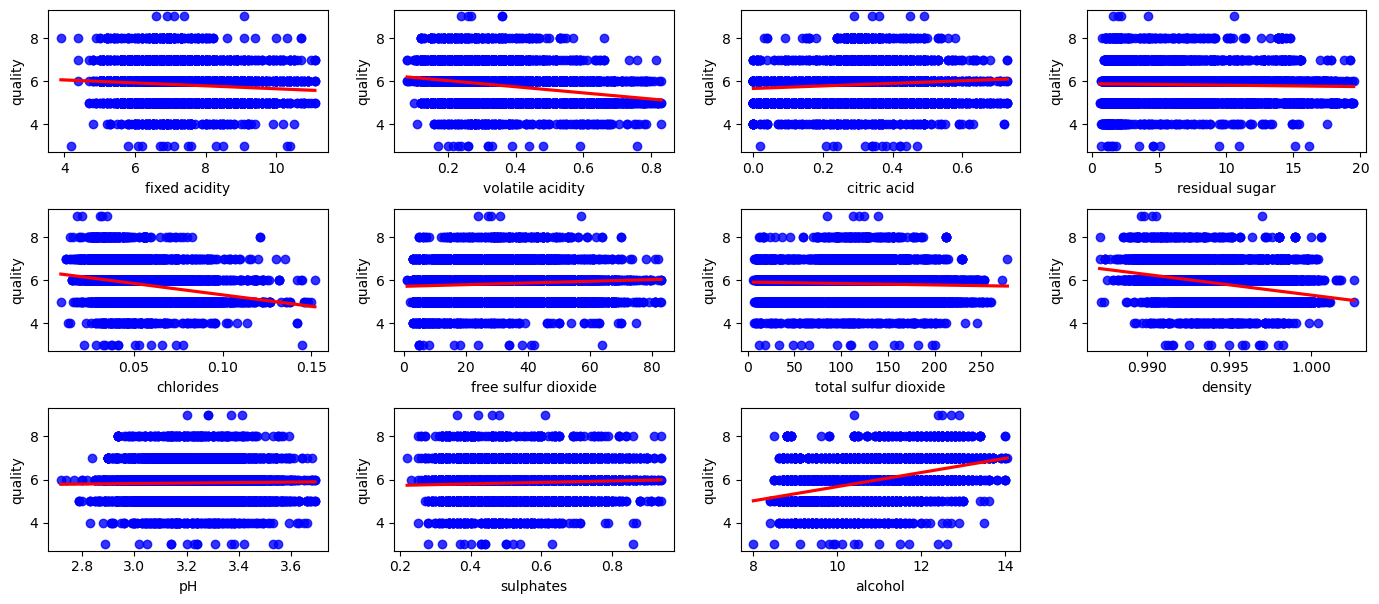

In [23]:
columns = df_out.drop(['quality', 'type'], axis = 1)
x = columns
y = df_out['quality']
fig, axs = plt.subplots(3,4, figsize=(14, 6))
fig.tight_layout (h_pad=2)
fig.delaxes(ax=axs[2,3])
axs = axs.flatten()
for i, k in enumerate(columns):
    sns.regplot(y = y,
                x = x[k],
                ax = axs[i],
                scatter_kws = {"color": "blue"},
                line_kws = {"color": "red"})
plt.savefig('E:/Repositories/Projects/SVO/Netology/CRISP_DM/WIne_Quality/reports/regplot.png')

Проверим является корреляция между параметрами статистически значимой. Нулевой гипотезой у нас будет то, что i-ая независимая переменная не имеет никакого влияния на целевую переменную. Уровень значимости возьмем: α = 0.05.


In [24]:
for i, k in enumerate(columns):
    pearson_f, p_value = stats.pearsonr(df_out['quality'], df_out[k])
    print("Сила взаимосвязи между Quality и %s равна = %.2f"% (k, pearson_f), " Уровень значимости = %s"%(p_value))

Сила взаимосвязи между Quality и fixed acidity равна = -0.08  Уровень значимости = 1.663552547285111e-10
Сила взаимосвязи между Quality и volatile acidity равна = -0.24  Уровень значимости = 3.039099511939016e-78
Сила взаимосвязи между Quality и citric acid равна = 0.09  Уровень значимости = 7.83970348466525e-12
Сила взаимосвязи между Quality и residual sugar равна = -0.04  Уровень значимости = 0.0048370906945456055
Сила взаимосвязи между Quality и chlorides равна = -0.25  Уровень значимости = 4.2392112736965405e-86
Сила взаимосвязи между Quality и free sulfur dioxide равна = 0.07  Уровень значимости = 1.2340611642943718e-08
Сила взаимосвязи между Quality и total sulfur dioxide равна = -0.04  Уровень значимости = 0.0012694668507051375
Сила взаимосвязи между Quality и density равна = -0.32  Уровень значимости = 1.3263262589703554e-137
Сила взаимосвязи между Quality и pH равна = 0.02  Уровень значимости = 0.11188245268864597
Сила взаимосвязи между Quality и sulphates равна = 0.05  Уровен

Как видим, p-value < 0.05. Это значит, что полученные нами результаты статистически значимы, и мы можем отбросить нулевую гипотезу.

По итогу корреляционного анализа мы определили, что некоторые признаки сильно коррелируют, а некоторые, напротив, демонстрируют слабую корреляцию с нашим целевым значением. Например, сульфаты и pH имеют корреляцию с целевой переменной около 0. Возможно, имеет смысл исключить их из дальнейшего анализа.

In [25]:
import os
outname = 'Wine_qual_EDA.csv'
outdir = 'E:/Repositories/Projects/SVO/Netology/CRISP_DM/WIne_Quality/data/processed'
if not os.path.exists(outdir):
    os.mkdir(outdir)
fullname = os.path.join(outdir, outname)
df_out.to_csv(fullname)


